In [21]:
import numpy as np

from human_terms_network import Human_Terms_Network
from dataset_load import *
from lr_baseline import LRBaseline

In [22]:
# open_pickle in dataset_load

X_train_original, X_test_original, y_train_original, y_test_original = load_imdb('../../data/imdb')

In [23]:
word_list, connotation = load_unigrams('./imdb-unigrams.txt', X_train_original, y_train_original)

In [24]:
y_train_agreement, y_test_agreement = generate_appearance(X_train_original, X_test_original, 
                                                          word_list, connotation)

In [25]:
imdb_baseline = LRBaseline(X_train_original, X_test_original, y_train_original, y_test_original, 
                           human_terms=word_list)

In [26]:
print(imdb_baseline.baseline())
print(imdb_baseline.baseline(penalty='l1'))
print(imdb_baseline.human_terms_baseline())
print(imdb_baseline.human_terms_baseline(penalty='l1'))

(0.94536, 0.86476)
(0.9424, 0.87184)
(0.81476, 0.81072)
(0.81452, 0.81056)


In [27]:
X_train = imdb_baseline.human_terms_cv.transform(X_train_original)
X_test = imdb_baseline.human_terms_cv.transform(X_test_original)
y_train = y_train_original
y_test = y_test_original

In [32]:
indices = np.where(np.sum(X_train,axis=1)!=0)[0]
X_test_nreject = X_test[indices]
y_test_nreject = y_test[indices]

In [34]:
y_test_nreject.shape

(22614,)

In [38]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=43, penalty='l1')
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

print(clf.score(X_test_nreject, y_test_nreject))
print((X_test.shape[0] - len(indices))/X_test.shape[0])
print(X_test.shape[0] - len(indices))

0.81472
0.81068
0.8109135933492527
0.09544
2386


In [7]:
X_train = imdb_baseline.baseline_cv.transform(X_train_original)
X_test = imdb_baseline.baseline_cv.transform(X_test_original)
y_train = y_train_original
y_test = y_test_original

In [20]:
X_test[10]

<1x3686 sparse matrix of type '<class 'numpy.int64'>'
	with 224 stored elements in Compressed Sparse Row format>

In [8]:
imdb_htm = Human_Terms_Network(input_shape=X_train.shape[1],
                               human_terms_shape=len(word_list),
                              domain='imdb')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3686)              0         
_________________________________________________________________
tanh_output (Dense)          (None, 1)                 3687      
Total params: 3,687
Trainable params: 3,687
Non-trainable params: 0
_________________________________________________________________
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 83)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 3686)         0                                            
_________________________________________

In [9]:
# imdb_htm.combined.load_weights('./combined/combined-weight-improvement-10-0.34.hdf5')

In [10]:
imdb_htm.set_data(X_train, X_test, y_train_agreement, y_test_agreement, y_train, y_test)

Train on 16666 samples, validate on 8334 samples
Epoch 1/1
16666/16666 [==============================] - 44s 3ms/step - loss: 0.4152 - acc: 0.6724 - val_loss: 0.3811 - val_acc: 0.7664
Train on 16666 samples, validate on 8334 samples
Epoch 1/1
16666/16666 [==============================] - 114s 7ms/step - loss: 0.7580 - acc: 0.3039 - val_loss: 0.7333 - val_acc: 0.3212

Epoch 00001: val_acc improved from -inf to 0.32121, saving model to ./imdb/combined-weight-improvement-01-0.32.hdf5


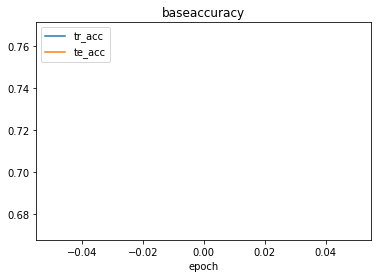

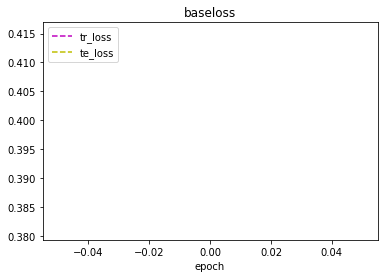

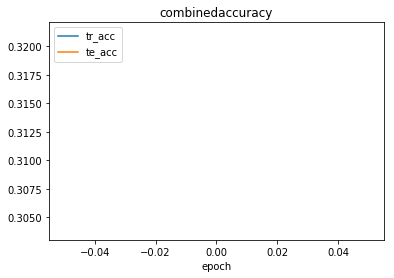

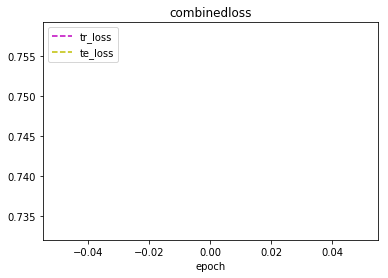

<Figure size 432x288 with 0 Axes>

In [11]:
imdb_htm.train(epochs=1)

In [16]:
imdb_htm.test(reject=True)

# 0.4 with validation_split = 0.33

21729/21729 [==============================] - 2s 94us/step


([0.6867370763854879, 0.36840167518063416], 0.13084)

array([-1,  1, -1, ..., -1,  1,  1])

In [17]:
imdb_htm.combined.evaluate([X_test, y_test_agreement], y_test_original)

25000/25000 [==============================] - 2s 94us/step


[0.7230736213302612, 0.3202]

In [19]:
imdb_htm.combined.evaluate([X_train, y_train_agreement], y_train_original)

25000/25000 [==============================] - 2s 92us/step


[0.6910337403488159, 0.34264]

In [18]:
imdb_htm.test(reject=False)

25000/25000 [==============================] - 2s 92us/step


([0.7230736213302612, 0.3202], 0)

In [30]:
from keras.models import Model

human_terms_relu_model = Model(inputs=imdb_htm.combined.input,
                                            outputs=imdb_htm.combined.get_layer('concatenate').output)
predict_relu = human_terms_relu_model.predict([X_test, y_test_agreement])
accept_indices = np.where(np.sum(predict_relu, axis=1)!=0)
total_reject = X_test.shape[0] - len(accept_indices)
rejection_rate = total_reject/X_test.shape[0]

In [23]:
rejection_rate

0.99996

(25000, 83)

In [26]:
eval = imdb_htm.combined.evaluate([imdb_htm.X_test, imdb_htm.y_test_agreement], imdb_htm.y_test)

25000/25000 [==============================] - 1s 54us/step


In [20]:
eval

[0.7428042534065247, 0.7199926891326904, 0.33156]